In [109]:
import mne
from pathlib import Path
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

raw = mne.io.read_raw_brainvision(
    Path("/mnt/d/thesis/sat1/eeg4/MD3-0021.vhdr"), preload=False
)
raw.set_channel_types(
    {"EOGh": "eog", "EOGv": "eog", "A1": "misc", "A2": "misc"}
)  # Declare type to avoid confusion with EEG channels
raw.rename_channels({"FP1": "Fp1", "FP2": "Fp2"})  # Naming convention
raw.set_montage("standard_1020")  # Standard 10-20 electrode montage
raw.rename_channels({"Fp1": "FP1", "Fp2": "FP2"})

montage = raw.get_montage()


def get_positions(montage):
    labels = []
    positions = []
    for item in montage.get_positions()["ch_pos"].items():
        labels.append(item[0])
        positions.append(item[1])
    positions = np.array(positions)
    return positions, labels


def cluster_positions(positions, dims=["x", "y", "z"]):
    if "z" not in dims:
        positions = np.delete(positions, 2, axis=1)
    if "y" not in dims:
        positions = np.delete(positions, 1, axis=1)
    if "x" not in dims:
        positions = np.delete(positions, 0, axis=1)
    km = KMeans(n_clusters=6, max_iter=1000, random_state=42, init="random", n_init=100)
    clusters = km.fit_predict(positions)

    return clusters

Extracting parameters from /mnt/d/thesis/sat1/eeg4/MD3-0021.vhdr...
Setting channel info structure...


/tmp/ipykernel_343/3934727202.py:10: RuntimeWarning: The unit for channel(s) A1, A2 has changed from V to NA.
  raw.set_channel_types(
/tmp/ipykernel_343/3934727202.py:14: RuntimeWarning: Not setting positions of 2 misc channels found in montage:
['A1', 'A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage("standard_1020")  # Standard 10-20 electrode montage


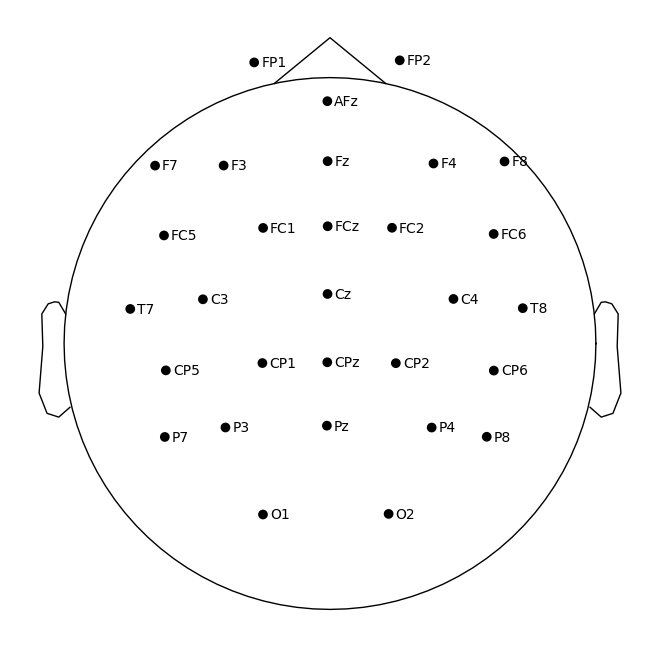

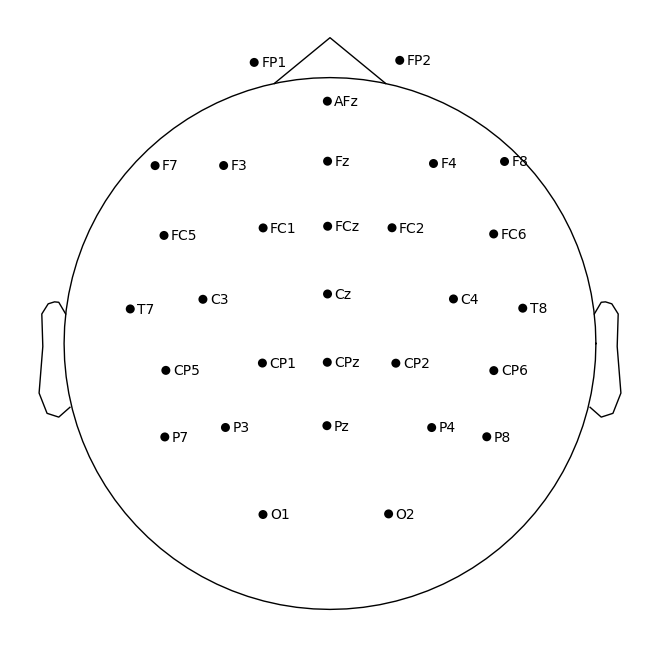

In [147]:
montage.plot()

In [140]:
positions, labels = get_positions(montage)
clusters = cluster_positions(positions, dims=["x"])

In [141]:
x = positions[:, 0]
y = positions[:, 1]
z = positions[:, 2]

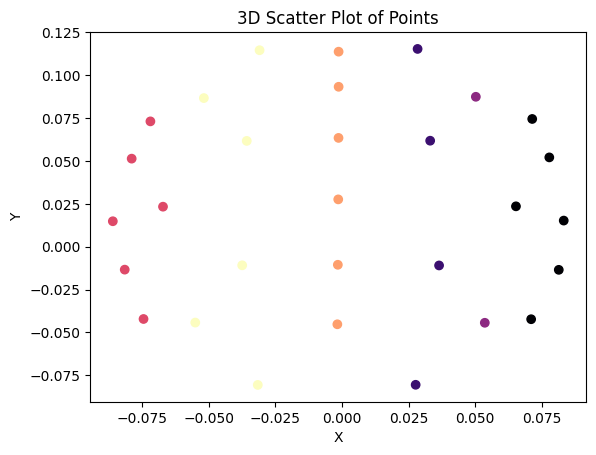

In [152]:
fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
ax = fig.add_subplot()
ax.scatter(x, y, c=clusters, cmap="magma")
ax.set_xlabel("X")
ax.set_ylabel("Y")
# ax.set_zlabel("Z")
ax.set_title("3D Scatter Plot of Points")
plt.show()

In [154]:
iter_nn_pos = positions.copy()

In [157]:
iter_nn_pos.shape

(30, 3)

In [159]:
for i in range(iter_nn_pos.shape[0]):
    print(iter_nn_pos[i, :])

[-0.03090259  0.11458518  0.02786657]
[0.0284095  0.11534631 0.02772126]
[-0.00123738  0.11373993  0.07038366]
[-0.07187663  0.07310353  0.02579046]
[-0.05180904  0.0866879   0.07871409]
[-0.00122927  0.09327445  0.10263929]
[0.05027428 0.08743839 0.07727065]
[0.07143527 0.07450513 0.02510103]
[-0.08598208  0.01487164  0.03117337]
[-0.06714872  0.02335823  0.10451068]
[-0.00137413  0.02761709  0.14019949]
[0.06532888 0.0235731  0.10369243]
[0.08326137 0.01525819 0.03097297]
[-0.07445796 -0.04212316  0.04127363]
[-0.05503823 -0.0442103   0.09990898]
[-0.00170945 -0.04521299  0.12667292]
[ 0.05363602 -0.04433452  0.10051603]
[ 0.07103247 -0.04225998  0.04119886]
[-0.03157356 -0.08056835  0.05478965]
[ 0.0276831  -0.08048884  0.05473408]
[-0.03571586  0.06171406  0.11798302]
[-0.00127143  0.06345979  0.12657198]
[0.03313098 0.06182849 0.1167817 ]
[-0.07890598  0.05136738  0.06296235]
[0.07784662 0.05209881 0.06286711]
[-0.08151351 -0.01334569  0.07313263]
[-0.03742513 -0.01082424  0.13344

In [ ]:
# Brute-force approach, not working (or taking prohibitively long)
from itertools import combinations, permutations


def distance(a, b):
    return np.linalg.norm(a - b)


def total_distance(clusters):
    return (
        sum(distance(a, b) for cluster in clusters for a in cluster for b in cluster)
        / 2.0
    )


positions, labels = get_positions(montage)

sizes = [5, 6]

best_distance = float("inf")
best_clusters = None

for size in sizes:
    n_clusters = len(positions) // size
    for cluster_indices in combinations(range(len(positions)), n_clusters * size):
        print(cluster_indices)
        for partition in permutations(cluster_indices, len(cluster_indices)):
            clusters = [
                tuple(sorted(partition[i : i + size]))
                for i in range(0, len(partition), size)
            ]
            dist = total_distance(
                [[positions[i] for i in cluster] for cluster in clusters]
            )
            if dist < best_distance:
                best_distance = dist
                best_clusters = clusters

# Convert cluster indices to actual clusters
best_clusters = [[positions[i] for i in cluster] for cluster in best_clusters]

print("Best total intra-cluster distance:", best_distance)
print("Best clusters:", best_clusters)